# Kaggle Competition: Spaceship Titanic

In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly.

#### Datasets:
- Train: Personal records for about 2/3 of passengers, to be used as training data
- Test: Personal records for the remaining 1/3 of the passengers, to be used as test data. The goal is to predict the value of 'Transported' in this set.

## Metadata

- **PassengerId (str)** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **HomePlanet (str)** - The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep (bool)** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin (str)** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **Destination (str)** - The planet the passenger will be debarking to.
- **Age (float)** - The age of the passenger.
- **VIP (bool)** - Whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck (float)** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name (str)** - The first and last names of the passenger.
- **Transported (bool)** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

# Loading train set and data cleaning

In [2]:
# Loading dataset

train = pd.read_csv('train.csv')

# split Cabin to extract more information

train['Deck'] = train['Cabin'].str.split(pat='/', expand=True)[0]
train['CabinNum'] = train['Cabin'].str.split(pat='/', expand=True)[1]
train['Side'] = train['Cabin'].str.split(pat='/', expand=True)[2]

# assign dtypes for less memory usage

column_mapper = {
    'HomePlanet':'category',
    'CryoSleep':'bool',
    'Destination':'category',
    'VIP':'bool',
    'Transported':'int'
}

train = train.astype(column_mapper).drop('Cabin', axis=1)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PassengerId   8693 non-null   object  
 1   HomePlanet    8492 non-null   category
 2   CryoSleep     8693 non-null   bool    
 3   Destination   8511 non-null   category
 4   Age           8514 non-null   float64 
 5   VIP           8693 non-null   bool    
 6   RoomService   8512 non-null   float64 
 7   FoodCourt     8510 non-null   float64 
 8   ShoppingMall  8485 non-null   float64 
 9   Spa           8510 non-null   float64 
 10  VRDeck        8505 non-null   float64 
 11  Name          8493 non-null   object  
 12  Transported   8693 non-null   int64   
 13  Deck          8494 non-null   object  
 14  CabinNum      8494 non-null   object  
 15  Side          8494 non-null   object  
dtypes: bool(2), category(2), float64(6), int64(1), object(5)
memory usage: 849.3+ KB


In [3]:
# Proportion of observations with positive y variable, is well represented, won't have this risk for biasing the model

train['Transported'].value_counts(normalize=True)

Transported
1    0.503624
0    0.496376
Name: proportion, dtype: float64

In [4]:
# Testing to just drop rows with NA values

train_clean = train.dropna(axis=0)
train_clean.shape

(6943, 16)

In [5]:
# After removing Na rows, the same proportion of y-positive is maintained and it doesn't loose significant part of sample

sample_maintained = train_clean.shape[0] / train.shape[0]
print(f'Percentage of sample maintained:',sample_maintained)
train_clean['Transported'].value_counts(normalize=True)

Percentage of sample maintained: 0.798688600023007


Transported
1    0.503961
0    0.496039
Name: proportion, dtype: float64

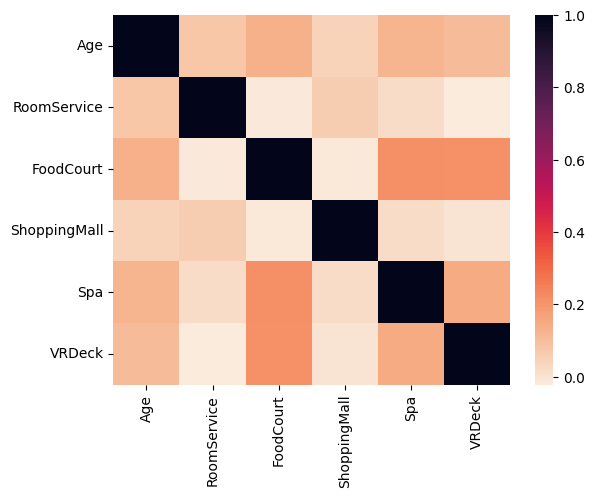

In [6]:
# Checking multicollinearity: not observable in continuous columns

df_continuous = train_clean[['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']]
df_continuous_corr = df_continuous.corr()

cmap = sns.cm.rocket_r
sns.heatmap(df_continuous_corr, cmap = cmap)
plt.show()

## Normalizing data

**Normalization vs Standardization**

- Normalization (min-max): scales data to a range from 0 and 1
$$
X_{normal.} = \frac{X-X_{min}}{X_{max}-X_{min}}
$$
- Stardardization: transform data to have a mean ($\mu$) of 0 and standard dev ($\sigma$) of 1
$$
X_{stand.} = \frac{X-\mu}{\sigma}
$$
<br> As Logistic Regression assumes a normal distribution, I'll be using a Z-score standardization

In [7]:
continuous_features = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

In [8]:
# Z-Score normalize the continuous variables

standard_scaler = StandardScaler()

X_standard = standard_scaler.fit_transform(train_clean[continuous_features])
X_standard

array([[ 0.69629653, -0.34238591, -0.28512436, -0.30894197, -0.27512286,
        -0.26835819],
       [-0.33463612, -0.17506205, -0.27977129, -0.26477498,  0.20929638,
        -0.22923897],
       [ 2.00214456, -0.27637741,  1.84183224, -0.30894197,  5.64996851,
        -0.22479361],
       ...,
       [-0.19717843, -0.34238591, -0.28512436,  2.99828236, -0.27424049,
        -0.26835819],
       [ 0.21519463, -0.34238591,  0.3388067 , -0.30894197,  0.03635254,
         2.60779324],
       [ 1.03994075, -0.14896567,  2.50323485, -0.30894197, -0.27512286,
        -0.25768931]])

From 6943 observations,  4546  are 0 for selected column


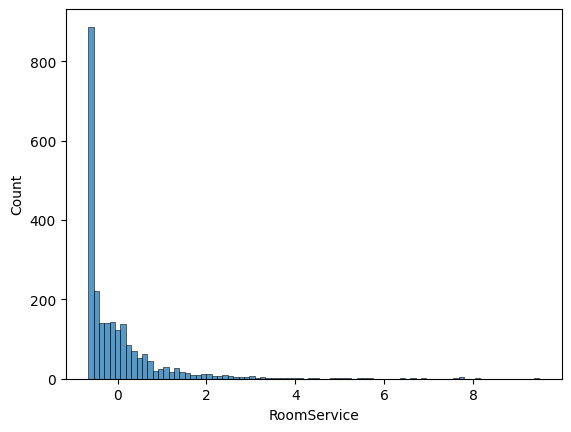

In [9]:
# input: column to check distribution
lookup_col = 'RoomService'

# calculation
df_cont_lookup = df_continuous[df_continuous[lookup_col] > 0]
lookup_standard = standard_scaler.fit_transform(df_cont_lookup)
cont_lookup = pd.DataFrame(lookup_standard, columns=continuous_features)

# output
not_zeros = X_standard.shape[0] - cont_lookup.shape[0]
print(f'From', X_standard.shape[0], 'observations, ', not_zeros, ' are 0 for selected column')
sns.histplot(data=cont_lookup, x=lookup_col);

In [10]:
# Convert transported to array to append
transported_arr = train_clean['Transported'].to_numpy()
transported_arr = transported_arr[:, np.newaxis]

# Create df with normalized cont var and transported
X_yappended = np.append(X_standard, transported_arr, axis=1)
cont_standard = pd.DataFrame(X_yappended, columns= np.append(continuous_features, ['Transported'], axis=0))
cont_standard

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0.696297,-0.342386,-0.285124,-0.308942,-0.275123,-0.268358,0.0
1,-0.334636,-0.175062,-0.279771,-0.264775,0.209296,-0.229239,1.0
2,2.002145,-0.276377,1.841832,-0.308942,5.649969,-0.224794,0.0
3,0.283923,-0.342386,0.477987,0.346496,2.662275,-0.096767,0.0
4,-0.884467,0.122744,-0.243489,-0.042173,0.223414,-0.266580,1.0
...,...,...,...,...,...,...,...
6938,0.833754,-0.342386,3.770725,-0.308942,1.174605,-0.202567,0.0
6939,-0.747009,-0.342386,-0.285124,-0.308942,-0.275123,-0.268358,0.0
6940,-0.197178,-0.342386,-0.285124,2.998282,-0.274240,-0.268358,1.0
6941,0.215195,-0.342386,0.338807,-0.308942,0.036353,2.607793,0.0


## Treating categorical as dummies

In [11]:
train_clean['CryoSleep'] = train_clean.loc[:,'CryoSleep'].astype(int)
train_clean['VIP'] = train_clean.loc[:,'VIP'].astype(int)
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6943 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PassengerId   6943 non-null   object  
 1   HomePlanet    6943 non-null   category
 2   CryoSleep     6943 non-null   int64   
 3   Destination   6943 non-null   category
 4   Age           6943 non-null   float64 
 5   VIP           6943 non-null   int64   
 6   RoomService   6943 non-null   float64 
 7   FoodCourt     6943 non-null   float64 
 8   ShoppingMall  6943 non-null   float64 
 9   Spa           6943 non-null   float64 
 10  VRDeck        6943 non-null   float64 
 11  Name          6943 non-null   object  
 12  Transported   6943 non-null   int64   
 13  Deck          6943 non-null   object  
 14  CabinNum      6943 non-null   object  
 15  Side          6943 non-null   object  
dtypes: category(2), float64(6), int64(3), object(5)
memory usage: 827.5+ KB


/tmp/ipykernel_7640/3121258568.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_clean['CryoSleep'] = train_clean.loc[:,'CryoSleep'].astype(int)
/tmp/ipykernel_7640/3121258568.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_clean['VIP'] = train_clean.loc[:,'VIP'].astype(int)


In [12]:
categorical_features = ['HomePlanet', 'Destination', 'Deck', 'CabinNum', 'Side']

In [13]:
# Using one hot encoding

df_categorical = train_clean[np.append(categorical_features, ['CryoSleep', 'VIP'], axis=0)]
df_categorical_encoded = pd.get_dummies(df_categorical, columns = categorical_features, dtype='int')
df_categorical_encoded

,CryoSleep,VIP,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,...,CabinNum_992,CabinNum_993,CabinNum_994,CabinNum_995,CabinNum_996,CabinNum_997,CabinNum_998,CabinNum_999,Side_P,Side_S
0,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,1,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
8689,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8690,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
8691,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### Question
Should I be using the drop_first = True?
<br> I understand the goal is to avoid multicolineality, is it being created in this case? Only if there was a constant?
<br> Should I use some technique to reduce the amount of parameters? Such as PCA?

# Logistic Regression

## Overview

Consists of a Linear Regression, $y$ being the dependent variable and $x_n$ explanatory variables:
$$
y = \beta_0 + \beta_1 X_1 + ...+ \beta_n X_n
$$
Applied into a Sigmoid function:
$$
p = \frac{1}{1+e^{-y}}
$$

<br> Therefore, Logistic regression is similar to linear regression, except that coefficients are in terms of *log(odds)*.
<br> Additionally, to fit the line based on coefficients to observed datapoints, logistic regression uses *Maximum Likelihood Estimation (MLE)* instead of Least Squares Method.
<br> 
<br> Outcome will be a classification between 0 and 1 probability for the y-variable. Here it will be the "Transported" variable.


## Using skitlearn

### Only continuous features

In [14]:
X = cont_standard[continuous_features]
y = cont_standard['Transported']

# Splitting the dataframes into train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=16) # randomization is part of this sklearn algorithm
print(f"{len(X_train)} examples in train the set and {len(X_valid)} examples in the validation set")

5207 examples in train the set and 1736 examples in the validation set


In [15]:
# Fitting the model to train sets and making the prediction on valiation

logreg = LogisticRegression(random_state=16)

classifier_cont = logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_valid)

y_pred

array([1., 1., 0., ..., 0., 1., 1.])

In [16]:
#Comparing validation and predition for confustion matrix

cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[583, 306],
       [ 86, 761]])

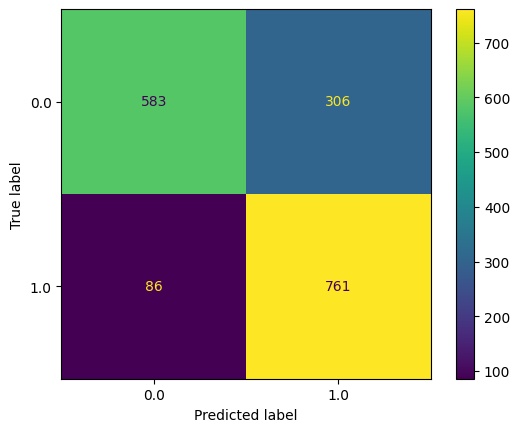

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier_cont, X_valid, y_valid);

In [18]:
# Detailing the Confusion Matrix results

print(f'True negatives: ', cnf_matrix[0][0])
print(f'False negatives: ', cnf_matrix[1][0])
print(f'True positive: ', cnf_matrix[1][1])
print(f'False positive: ', cnf_matrix[0][1])

True negatives:  583
False negatives:  86
True positive:  761
False positive:  306


In [19]:
# Measure of accuracy

from sklearn.metrics import accuracy_score
accuracy_norm = accuracy_score(y_valid, y_pred, normalize=True)
accuracy_count = accuracy_score(y_valid, y_pred, normalize=False)
print(f'Accuracy = ', round(accuracy_count), ' right predictions, ', round(accuracy_norm,2), ' score') 

Accuracy =  1344  right predictions,  0.77  score


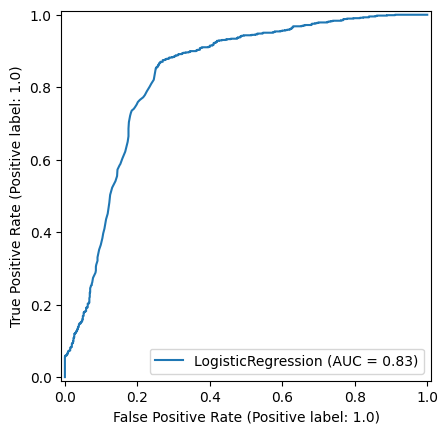

In [20]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(classifier_cont, X_valid, y_valid)

In [21]:
# Feture importance

classifier_cont_coeff_values = np.append(classifier_cont.coef_, np.exp(classifier_cont.coef_), axis=0)
classifier_cont_coeff = pd.DataFrame(classifier_cont_coeff_values, columns = continuous_features, index = ['Beta Coeff','Odds Ratio'])
classifier_cont_coeff

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
Beta Coeff,0.004277,-1.319552,1.195443,0.112384,-2.680501,-2.340234
Odds Ratio,1.004286,0.267255,3.305022,1.118943,0.068529,0.096305


Beta Coeff:
- Positive Coefficient: increase in the predictor variable **increases** the log odds of the positive class.
- Negative Coefficient: increase in the predictor variable **decreases** the log odds of the positive class.
<br>
<br>
- Odds Ratio > 1: increases the odds of the outcome.
- Odds Ratio < 1: decreases the odds of the outcome.
- Odds Ratio = 1: does not affect the odds of the outcome.
<br>
<br> Important to have in mind that the continuous variables were standardized, so it shows relative importance.
<br> The test dataframe also needs to be standardized in order to use this model.

### Question:
Age has a small importance for the prediction.
<br> In econometry, you could do a Wald's test for the hypothesis that Beta Coeff of Age = 0 under 0.05 significance, if it is accepted you can remove this parameter. How would you treat this from a ML POV?

### Continuous and categorical features

In [22]:
append_cat_cont = np.append(df_categorical_encoded, cont_standard, axis=1)
full_df = pd.DataFrame(append_cat_cont, columns = np.append(df_categorical_encoded.columns, cont_standard.columns, axis=0))
full_df

,CryoSleep,VIP,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,...,CabinNum_999,Side_P,Side_S,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.696297,-0.342386,-0.285124,-0.308942,-0.275123,-0.268358,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,-0.334636,-0.175062,-0.279771,-0.264775,0.209296,-0.229239,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,2.002145,-0.276377,1.841832,-0.308942,5.649969,-0.224794,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.283923,-0.342386,0.477987,0.346496,2.662275,-0.096767,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,-0.884467,0.122744,-0.243489,-0.042173,0.223414,-0.266580,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6938,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.833754,-0.342386,3.770725,-0.308942,1.174605,-0.202567,0.0
6939,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.747009,-0.342386,-0.285124,-0.308942,-0.275123,-0.268358,0.0
6940,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,-0.197178,-0.342386,-0.285124,2.998282,-0.274240,-0.268358,1.0
6941,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.215195,-0.342386,0.338807,-0.308942,0.036353,2.607793,0.0


In [23]:
X = full_df.loc[:, ~full_df.columns.isin(['Transported'])]
y = full_df['Transported']

# Splitting the dataframes into train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=16) # randomization is part of this sklearn algorithm
print(f"{len(X_train)} examples in train the set and {len(X_valid)} examples in the validation set")

5207 examples in train the set and 1736 examples in the validation set


In [24]:
# Fitting the model to train sets and making the prediction on valiation

logreg = LogisticRegression(random_state=16)

classifier_complete = logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_valid)

y_pred

array([1., 1., 0., ..., 0., 0., 1.])

In [25]:
#Comparing validation and predition for confustion matrix

cnf_matrix = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix

array([[673, 216],
       [171, 676]])

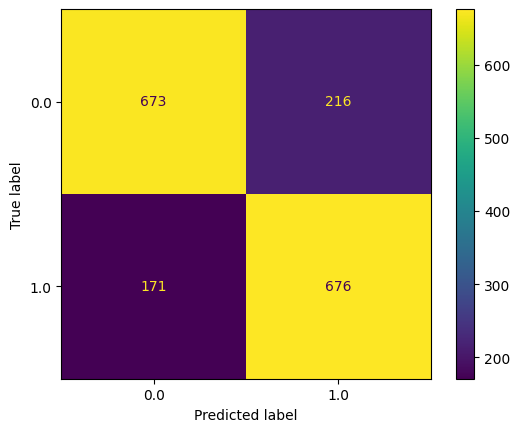

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier_complete, X_valid, y_valid);

In [27]:
# Measure of accuracy

from sklearn.metrics import accuracy_score
accuracy_norm = accuracy_score(y_valid, y_pred, normalize=True)
accuracy_count = accuracy_score(y_valid, y_pred, normalize=False)
print(f'Accuracy = ', round(accuracy_count), ' right predictions, ', round(accuracy_norm,2), ' score') 

Accuracy =  1349  right predictions,  0.78  score


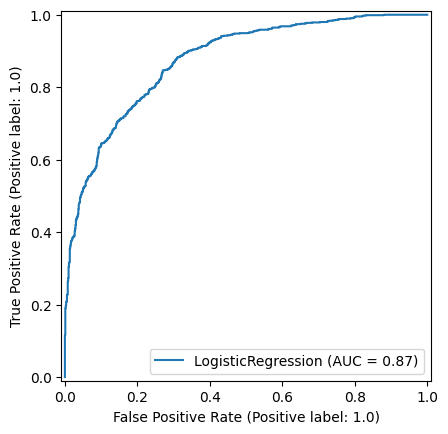

In [28]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(classifier_complete, X_valid, y_valid)

- ROC: A receiver operating characteristic, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate).
- AUC: area under the curve, translates the ROC curve into a single number. Probabiliadde de, se o modelo receber um exemplo positivo e negativo aleatoriamente, classificará positivo maior que negativo.

### Question:
What is the possible reason for the final accuracy being so similar, but distribution between types of errors so different (much more false negatives in this case)
<br> This is cleary visible when comparing the too ROC curves as well
<br> How can I make an analysis of feature importance with so many different dummy variables? NUM_AS_ROOT

## Examples

To understand how Logistic Regression works, let's use some columns from the dataset to do an example if continuous data and another with discrete data.

### Continuous variables

Y-axis in logistic regression (between 0 and 1) is transformed from "probability of transported" to "log(odds of transported)", so it will be able to go from -infty to +infty
<br>In chart on the left, we can create a linear regression with coefficients. It works the same, but in a scale of log(odds)
<br>.

<img src="../images/logistic_regression_continuous.png" alt="Continuous Regression" width="800"/>

In [29]:
cont_standard

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0.696297,-0.342386,-0.285124,-0.308942,-0.275123,-0.268358,0.0
1,-0.334636,-0.175062,-0.279771,-0.264775,0.209296,-0.229239,1.0
2,2.002145,-0.276377,1.841832,-0.308942,5.649969,-0.224794,0.0
3,0.283923,-0.342386,0.477987,0.346496,2.662275,-0.096767,0.0
4,-0.884467,0.122744,-0.243489,-0.042173,0.223414,-0.266580,1.0
...,...,...,...,...,...,...,...
6938,0.833754,-0.342386,3.770725,-0.308942,1.174605,-0.202567,0.0
6939,-0.747009,-0.342386,-0.285124,-0.308942,-0.275123,-0.268358,0.0
6940,-0.197178,-0.342386,-0.285124,2.998282,-0.274240,-0.268358,1.0
6941,0.215195,-0.342386,0.338807,-0.308942,0.036353,2.607793,0.0
